In [105]:
#!pip install corpy
import pandas as pd
import numpy as np
import regex as re
from sklearn.feature_extraction.text import CountVectorizer
from visualization.utils import *
from sklearn.neighbors import LocalOutlierFactor
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from matplotlib import pyplot as plt
import time
tqdm.pandas()
pd.set_option('max_colwidth', 0)

In [106]:
data_with_similarity_dir = "./Data/Similarity/"
tagger_dir = './visualization/english-morphium-wsj-140304.tagger'
import_data_name = "data_explanation_prep_4_old.pickle"
neighbours = 4
base_model_name = "all-mpnet-base-v2"

In [143]:
def get_lof_score(dat):
    ad = []
    try:
        lof = LocalOutlierFactor(n_neighbors = neighbours,metric='cosine')
        embeds = dat.to_list()
        lof.fit_predict(embeds).tolist()
        return 1 - (1/(1-(lof.negative_outlier_factor_)))
    except:
        return [0.51]*len(dat)

def embeddings_sentence_bert(text, IsBase, Bert_name):
    
        start = time.time()
        if IsBase==True:            
            model = SentenceTransformer(Bert_name, device = 'cpu')  # model  bert-base-uncased           
        else:     
                     
            word_embedding_model = models.Transformer(Bert_name)
            
            # Apply mean pooling to get one fixed sized sentence vector
            
            pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                                           pooling_mode_mean_tokens=True,
                                           pooling_mode_cls_token=False,
                                           pooling_mode_max_tokens=False)
            
            model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device = 'cuda:0')

        
        #Sentences are encoded by calling model.encode()
        sentence_vectors = model.encode(text, show_progress_bar=True, batch_size = 10)            

        end = time.time()

        print("Time for creating "+ str(len(sentence_vectors))+" embedding vectors " + str((end - start)/60))
        print('Model used :'+ Bert_name )

        return sentence_vectors

In [108]:
words = list(pd.read_csv('./visualization/stopwords.csv',header=None,index_col=None)[0]) # NLTK library stopwords also used as synonyms
stop_words =set([re.sub(r"\'",r'',word).lower() for word in words])

In [109]:
data_sim = pd.read_pickle(data_with_similarity_dir + import_data_name) # data_explanation_prep_shortExplanation_prep.pickle"
data_sim['source_text_sentences'] = data_sim['source_text_sentences'].astype(str)
len(data_sim)

465236

In [110]:
data_sim.columns

Index(['index', 'id', 'reviewer', 'date', 'statement', 'explanation',
       'shortExplanation', 'truth_o_meter', 'tags', 'url', 'statement_prep',
       'explanation_prep', 'shortExplanation_prep',
       'statement_explanation_prep', 'statementTokensLength',
       'explanationTokensLength', 'shortExplanationTokensLength',
       'statementexplanationTokensLength', 'label', 'source_text',
       'target_text', 'source_text_sentences', 'source_text_sentences_len',
       'source_text_sentences_index', 'index',
       'source_text_sentences_embed_base', 'LOF_base'],
      dtype='object')

In [111]:
report = data_sim[data_sim.id == 942].sort_values('id', ascending=False)
#report[["statement_prep",'explanation_prep','source_text_sentences']] #.to_csv("one_report.csv",index = False) #.to_csv("one_report.csv",index = False) [0:2]

In [112]:
sentences_lst = report['source_text_sentences'].tolist()
#embeddings_1 = embeddings_sentence_bert(sentences_lst, True, base_model_name)
#report['bert_embedding'] = list(embeddings_1)

In [113]:
#report.sort_values('LOF_base', ascending=False)["url"]

In [114]:
report["row_index"] = list(range(1,len(report)+1))
report["row_index"]

30539    1 
30540    2 
30541    3 
30542    4 
30543    5 
30544    6 
30545    7 
30546    8 
30547    9 
30548    10
30549    11
30550    12
30551    13
30552    14
30553    15
30554    16
Name: row_index, dtype: int64

In [115]:
# create tagger instance for morphodita
tagger = Tagger(tagger_dir)
tt=["My grandfather died recently, He spent his final years as a regular user of facebook."]
print("Before preprocessing : ")
print(tt)
print("")
print("After preprocessing : ")
print(preprocess(tt,stop_words,tagger))

Before preprocessing : 
['My grandfather died recently, He spent his final years as a regular user of facebook.']

After preprocessing : 


  0%|          | 0/1 [00:00<?, ?it/s]

['grandfather die spend final year regular user facebook']


# Get word cloud 

/storage/brno3-cerit/home/vajp02/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of unique words in report:122


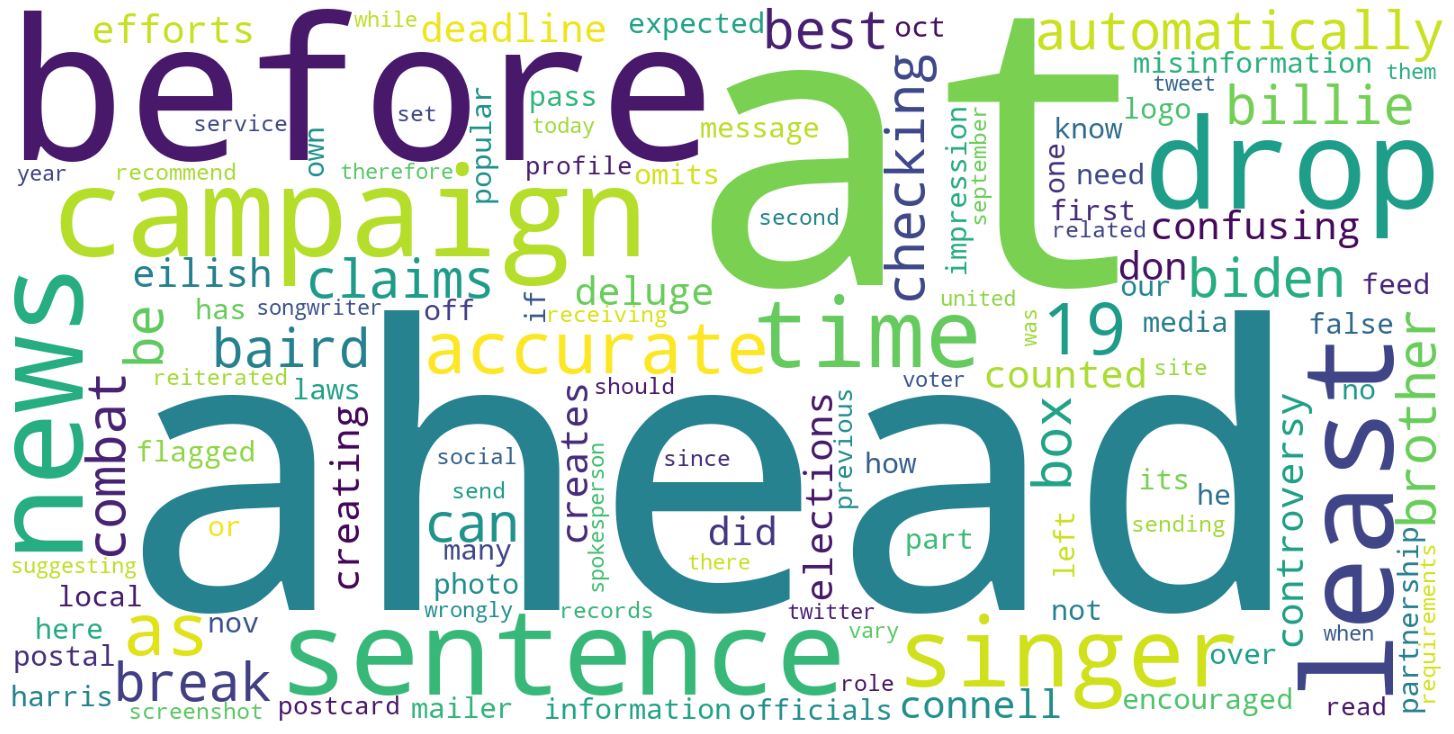

In [116]:
tf = CountVectorizer(min_df = 0, max_df = 1 ,ngram_range=(1, 1)) # no stopwords maybe stop_words=stop_words
text_col = report.source_text_sentences.to_list()
wordCloud(text_col,stop_words,tagger,tf,"one_gram_no_preprocess", False)

Number of unique words in report:58


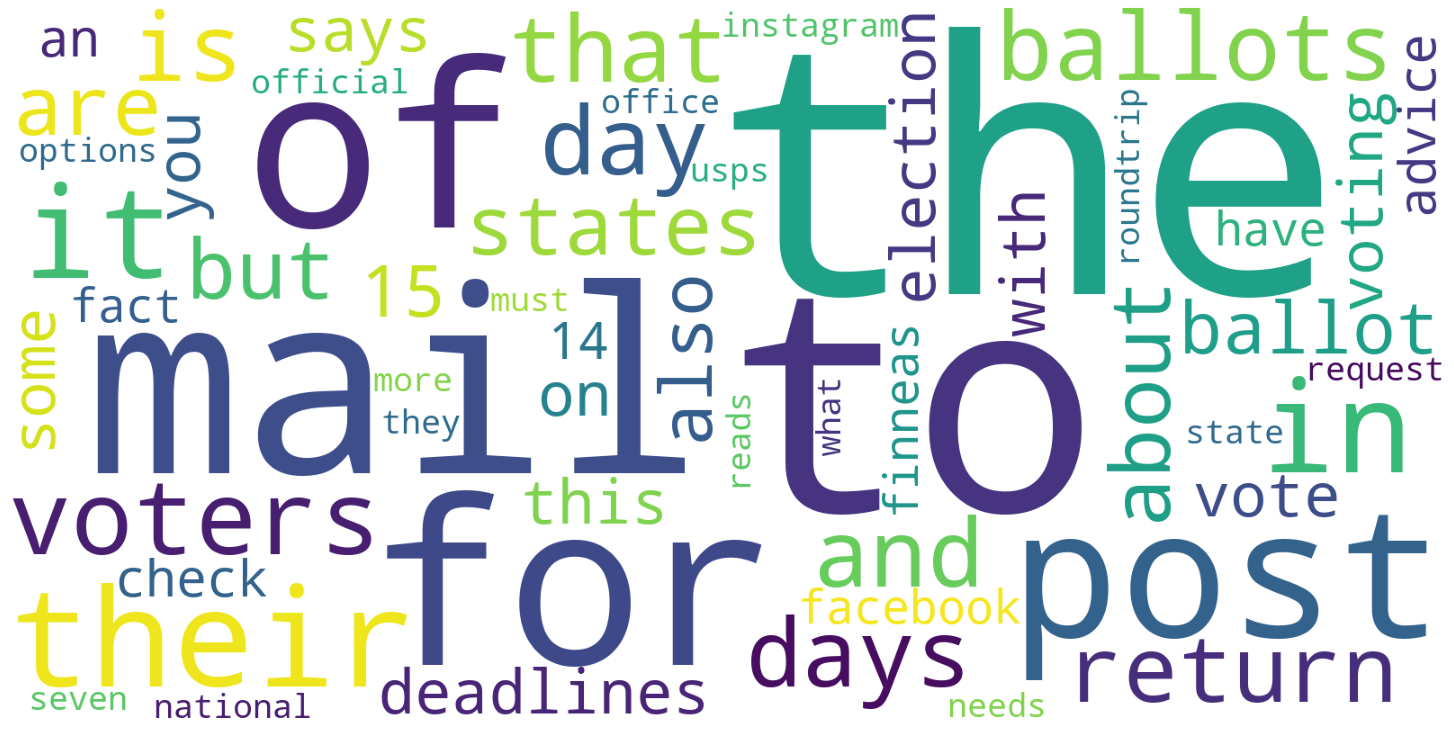

In [117]:
tf = CountVectorizer(min_df = 2, ngram_range=(1, 1)) # no stopwords maybe stop_words=stop_words
text_col = report.source_text_sentences.to_list()
wordCloud(text_col,stop_words,tagger,tf,"two_gram_no_preprocess", False)

  0%|          | 0/16 [00:00<?, ?it/s]

Number of unique words in report:74


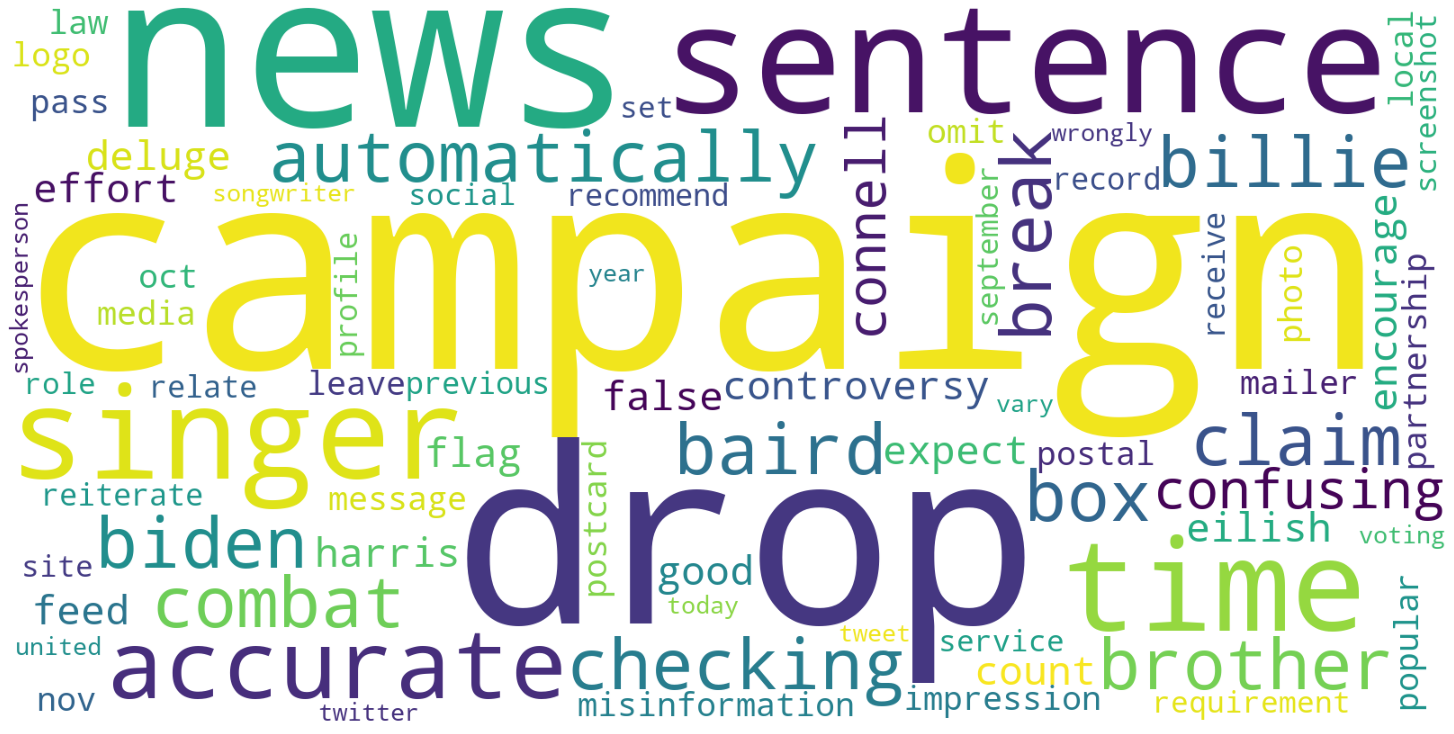

In [118]:
tf = CountVectorizer(min_df = 0, max_df = 1 ,ngram_range=(1, 1), stop_words=list(stop_words)) # no stopwords maybe stop_words=stop_words
text_col = report.source_text_sentences.to_list()
wordCloud(text_col,stop_words,tagger,tf,"one_gram_preprocess", True)

  0%|          | 0/16 [00:00<?, ?it/s]

Number of unique words in report:25


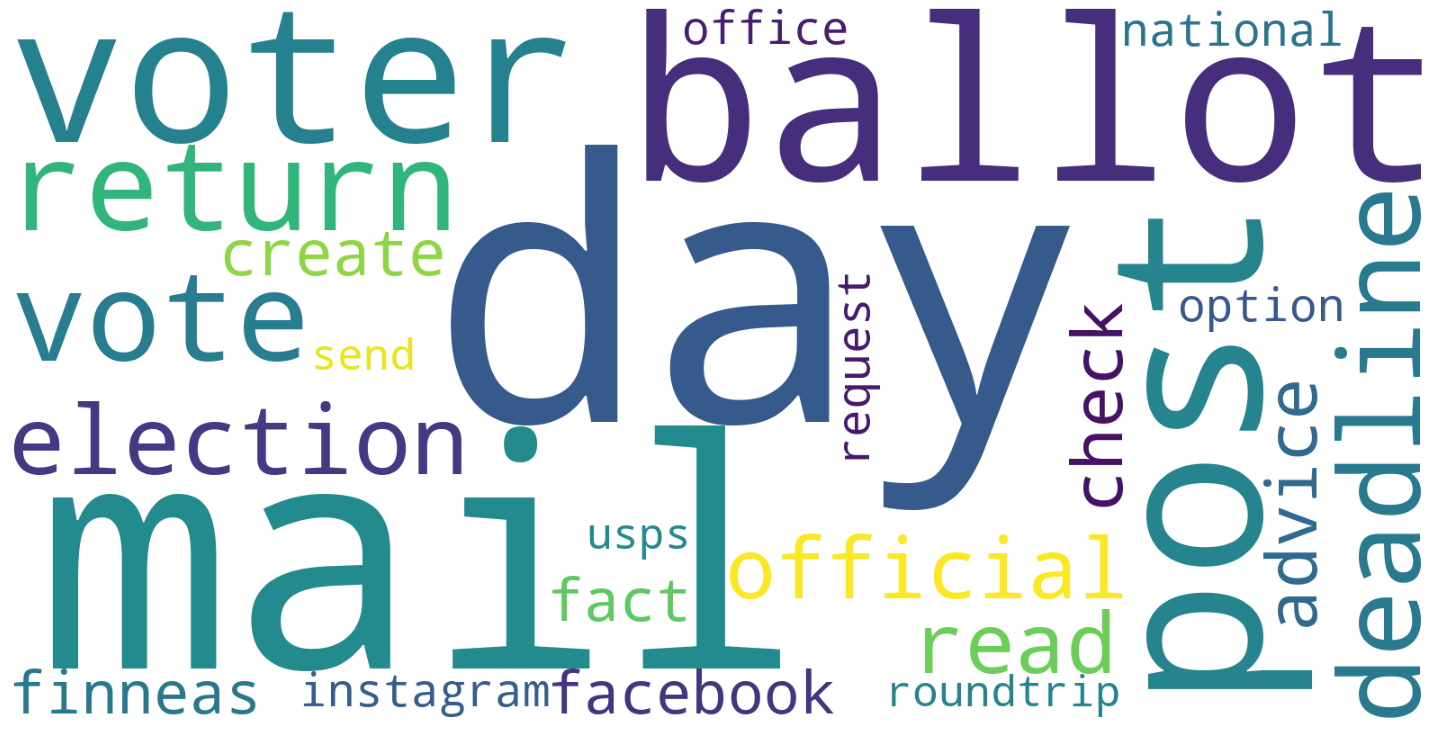

In [119]:
tf = CountVectorizer(min_df = 2, ngram_range=(1, 1), stop_words=list(stop_words)) # no stopwords maybe stop_words=stop_words
text_col = report.source_text_sentences.to_list()
wordCloud(text_col,stop_words,tagger,tf,"two_gram_preprocess", True)

# Tf-idf + LOF

In [160]:
tf_idf = TfidfVectorizer(min_df = 1, ngram_range=(1, 1), stop_words = stop_words)

In [161]:
text_prep = preprocess(text_col,stop_words,tagger)
# Trasform data to tf-idf matrix
X_tf_idf= transporttoTfIdf(text_prep,tf_idf, False)
report["tf-idf"] = list(X_tf_idf.astype(float))    

  0%|          | 0/16 [00:00<?, ?it/s]

In [162]:
lof = LocalOutlierFactor(n_neighbors = neighbours, metric = 'cosine')
report["LOF_tf-idf"] = report.groupby('id',sort = False)['tf-idf'].progress_apply(get_lof_score).explode().to_list()
#data_shorter.to_pickle(data_with_similarity_dir)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.89it/s]


In [163]:
report.columns

Index(['index', 'id', 'reviewer', 'date', 'statement', 'explanation',
       'shortExplanation', 'truth_o_meter', 'tags', 'url', 'statement_prep',
       'explanation_prep', 'shortExplanation_prep',
       'statement_explanation_prep', 'statementTokensLength',
       'explanationTokensLength', 'shortExplanationTokensLength',
       'statementexplanationTokensLength', 'label', 'source_text',
       'target_text', 'source_text_sentences', 'source_text_sentences_len',
       'source_text_sentences_index', 'index',
       'source_text_sentences_embed_base', 'LOF_base', 'row_index', 'tf-idf',
       'LOF_tf-idf', 'doc2vec_embed', 'LOF_doc2vec', 'bert_embedding',
       'LOF_Bert_baseline'],
      dtype='object')

In [164]:
X = report["LOF_tf-idf"].to_list() 
IDs = report.row_index.to_list()

In [165]:
range(1,len(X)+1)

range(1, 17)

In [166]:
IDs

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

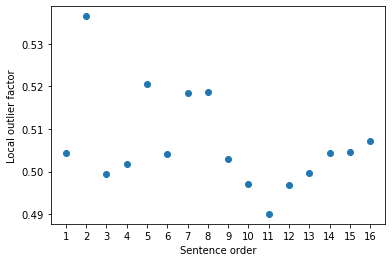

In [167]:
plt.scatter(IDs, X)
#plt.title("Local Outlier factor for each sentence in the report using tf-idf")
plt.xlabel('Sentence order')
plt.xticks(range(1,len(X)+1))
plt.ylabel('Local outlier factor')
plt.savefig('tf-idf-lof.png')

In [128]:
report.columns

Index(['index', 'id', 'reviewer', 'date', 'statement', 'explanation',
       'shortExplanation', 'truth_o_meter', 'tags', 'url', 'statement_prep',
       'explanation_prep', 'shortExplanation_prep',
       'statement_explanation_prep', 'statementTokensLength',
       'explanationTokensLength', 'shortExplanationTokensLength',
       'statementexplanationTokensLength', 'label', 'source_text',
       'target_text', 'source_text_sentences', 'source_text_sentences_len',
       'source_text_sentences_index', 'index',
       'source_text_sentences_embed_base', 'LOF_base', 'row_index', 'tf-idf',
       'LOF_tf-idf'],
      dtype='object')

In [129]:
report[["source_text_sentences","row_index"]]

,source_text_sentences,row_index
30539,The United States is expected to break records for voting mail this year and that’s creating a deluge of claims on social media about deadlines.,1
30540,"Some are accurate, some are not.",2
30541,"15 days left to vote BUT if you are voting mail, you need to vote TODAY, reads one popular Instagram post.",3
30542,USPS says it needs a 14 day roundtrip to be counted on election day. reads.,4
30543,This post was flagged as part of Facebook’s efforts to combat false news and misinformation on its News Feed.,5
30544,(Read more about our partnership with Facebook.),6
30545,"The post is a screenshot of an Oct. 19 tweet singer-songwriter Finneas Baird O Connell, brother of singer Billie Eilish.",7
30546,"Finneas’ Twitter profile photo is of the Biden/Harris campaign logo, but he has no official role with the campaign.",8
30547,The post wrongly creates the impression that there is a national deadline to vote mail.,9
30548,"It’s also a confusing message: the first sentence says voters must send it mail ballots 15 days ahead of time while the second sentence says the post office needs a 14-day roundtrip, suggesting that a voter can mail it in seven days ahead of time.",10


# Doc2vec + LOF

In [130]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#tokenize and tag the card text
card_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(report['source_text_sentences'].tolist())]

In [131]:
model = Doc2Vec(vector_size=64, window = 5 ,min_count=1, epochs = 5)

In [132]:
#build vocab
model.build_vocab(card_docs)
#train model
model.train(card_docs, total_examples=model.corpus_count
            , epochs=model.epochs)

In [133]:
#generate vectors
card2vec = [model.infer_vector((report['source_text_sentences'].tolist()[i].split(' '))) 
            for i in range(0,len(report['source_text_sentences'].tolist()))]

In [134]:
#Create a list of lists
dtv= np.array(card2vec).tolist()
#set list to dataframe column
report['doc2vec_embed'] = dtv

In [135]:
report["LOF_doc2vec"] = report.groupby('id', sort = False)['doc2vec_embed'].progress_apply(get_lof_score).explode().to_list()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 319.25it/s]


In [136]:
X = report["LOF_doc2vec"].to_list() 
IDs = report.row_index.to_list()

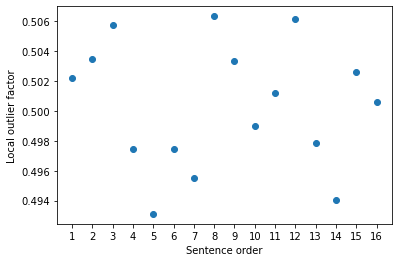

In [138]:
plt.scatter(IDs, X)
#plt.title("Local Outlier factor for each sentence in the report using doc2vec")
plt.xlabel('Sentence order')
plt.xticks(range(1,len(X)+1))
plt.ylabel('Local outlier factor')
plt.savefig('doc2vec-lof.png')

In [139]:
report.columns

Index(['index', 'id', 'reviewer', 'date', 'statement', 'explanation',
       'shortExplanation', 'truth_o_meter', 'tags', 'url', 'statement_prep',
       'explanation_prep', 'shortExplanation_prep',
       'statement_explanation_prep', 'statementTokensLength',
       'explanationTokensLength', 'shortExplanationTokensLength',
       'statementexplanationTokensLength', 'label', 'source_text',
       'target_text', 'source_text_sentences', 'source_text_sentences_len',
       'source_text_sentences_index', 'index',
       'source_text_sentences_embed_base', 'LOF_base', 'row_index', 'tf-idf',
       'LOF_tf-idf', 'doc2vec_embed', 'LOF_doc2vec'],
      dtype='object')

# Bert Base + LOF

In [151]:
#list(model.encode(["Ahoj","Ahoj nic"], show_progress_bar=True) )

In [152]:
model = SentenceTransformer(base_model_name, device = 'cpu')
report['bert_embedding'] = list(model.encode(report['source_text_sentences'].to_list(), show_progress_bar=True, batch_size = 10))

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [153]:
report["LOF_Bert_baseline"] = report.groupby('id',sort = False)['bert_embedding'].progress_apply(get_lof_score).explode().to_list()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.77it/s]


In [154]:
X = report["LOF_Bert_baseline"].to_list() 
IDs = report.row_index.to_list()

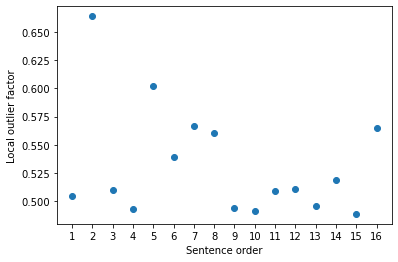

In [155]:
plt.scatter(IDs, X)
#plt.title("Local Outlier factor for each sentence in the report using tf-idf")
plt.xlabel('Sentence order')
plt.xticks(range(1,len(X)+1))
plt.ylabel('Local outlier factor')
plt.savefig('bert_base-lof.png')

# Bert tunned + LOF

In [43]:
X = report.LOF_base.to_list() 
IDs = report.row_index.to_list()

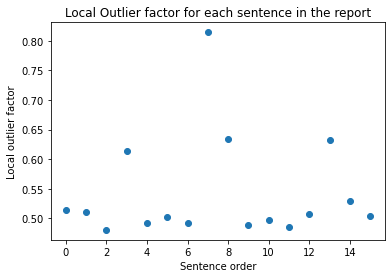

In [44]:
plt.scatter(IDs, X)
plt.title("Local Outlier factor for each sentence in the report")
plt.xlabel('Sentence order')
plt.ylabel('Local outlier factor')
plt.savefig('bert_tunned-lof.png')

In [45]:
report.columns

Index(['index', 'id', 'reviewer', 'date', 'statement', 'explanation',
       'shortExplanation', 'truth_o_meter', 'tags', 'url', 'statement_prep',
       'explanation_prep', 'shortExplanation_prep',
       'statement_explanation_prep', 'statementTokensLength',
       'explanationTokensLength', 'shortExplanationTokensLength',
       'statementexplanationTokensLength', 'label', 'source_text',
       'target_text', 'source_text_sentences', 'source_text_sentences_len',
       'source_text_sentences_index', 'index',
       'source_text_sentences_embed_base', 'LOF_base', 'bert_embedding',
       'row_index', 'tf-idf', 'LOF_tf-idf', 'doc2vec_embed', 'LOF_doc2vec',
       'LOF_Bert_baseline'],
      dtype='object')

In [ ]:
report = data_sim[data_sim.id == 942].sort_values('LOF_base', ascending=False)
t = report.LOF_base.to_list()
values = [i-j for i, j in zip(t[:-1], t[1:])]
print(np.argmax(values))
report.sort_values('LOF_base', ascending=False)[['source_text_sentences_index','statement_prep','source_text_sentences','LOF_base']]

In [ ]:
report.sort_values('LOF_base', ascending=False)[["statement_prep","row_index","id","source_text_sentences","url","explanationTokensLength","LOF_base"]][0:50]